## Data Cleaning & Preprocessing

Data source: [Kaggle: Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/olistbr/brazilian-ecommerce) and [Kaggle: Marketing Funnel by Olist](https://www.kaggle.com/olistbr/marketing-funnel-olist)

#### Project description:
Join the data files using the provided schema and perform some data wrangling

#### Content
1. Importing required libraries
2. Loading the datasets, creating dfs & changing dtypes
3. Joining datasets
	1. Merging products & category names
	2. Merging gelocations with customers & sellers dfs
	3. Joining ecommerce datasets
4. Cleaning sales dataframe
	1. Handling the missing values
	2. checking for duplicates & outliers
	3. Downcasting & saving the outcome
5. Joining marketing datasets
	1. Cleaning marketing dataset

### Data Schema
The data is provided in multiple datasets for better understanding and organization with the following data schema:

Overal Schema<br/>
<img src="https://github.com/mahnoushrodriguez/Data_Science/tree/main/images/images/MKT-Data_schema.png" alt="Data Schema" width="600"/><br/>

e-commerce Schema<br/>
<img src=".//images//Sales_schema.png" alt="e-commerce Schema" width="600"/>

<!-- ![Data Schema](MKT-Data_schema.png 'Data Schema') -->

### 1. Importing required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
import os  # to check file size & join paths
import gc # to garbage collect

In [2]:
# check the venv we are using
import sys
print(sys.executable)

c:\Users\mahno\Dropbox\CBO\.venv\Scripts\python.exe


### 2. Loading the datasets, creating dfs & changing dtypes

In [3]:
def create_df(file_path, file_name, date_cols, cols_to_change_dtype):
    # creating dfs, pasring dates & changing dtypes
    df = pd.read_csv(os.path.join(file_path, file_name), parse_dates=date_cols, dtype=cols_to_change_dtype, skipinitialspace=True)
    
    ## downcasting floats
    f_cols= df.select_dtypes(['float', 'float64']).columns
    df[f_cols] = df[f_cols].apply(pd.to_numeric, downcast='float')

    ## downcasting ints
    i_cols = df.select_dtypes(['integer', 'int', 'int32']).columns
    df[i_cols] = df[i_cols].apply(pd.to_numeric, downcast='unsigned')

    return df

In [4]:
# creating dfs
ecom = r'.\Brazilian_E-Commerce'
mkt = r'.\Brazilian_MKT'

customers = create_df(ecom, 'olist_customers_dataset.csv', [], {'customer_zip_code_prefix': object})
geolocations = create_df(ecom, 'olist_geolocation_dataset.csv', [], {'geolocation_zip_code_prefix': object})
items = create_df(ecom, 'olist_order_items_dataset.csv',[4], {})
payments = create_df(ecom, 'olist_order_payments_dataset.csv', [], {})
reviews = create_df(ecom, 'olist_order_reviews_dataset.csv', [5, 6], {})
orders = create_df(ecom, 'olist_orders_dataset.csv', [3, 4, 5, 6, 7], {})
products = create_df(ecom, 'olist_products_dataset.csv', [], {})
sellers = create_df(ecom, 'olist_sellers_dataset.csv', [], {'seller_zip_code_prefix': object})
categories = create_df(ecom, 'product_category_name_translation.csv', [], {})
closed_deals = create_df(mkt, 'olist_closed_deals_dataset.csv', [4], {})
mql = create_df(mkt, 'olist_marketing_qualified_leads_dataset.csv', [1], {})

In [5]:
# returning some df descreptives
def check_dfs(dfs):
    
    dfs_info = pd.DataFrame(columns=['df', 'column', 'count', 'nulls', 'dtype', 'smaple_value'])

    for k, v in dfs.items():
        df = pd.DataFrame(index=v.columns.values)
        df['df'] = k
        df['column'] = v.columns.values
        df['count'] = v.count()
        df['nulls'] = v.isna().sum()
        df['dtype'] = v.dtypes
        df['smaple_value'] = v.iloc[0]

        dfs_info = pd.concat([dfs_info, df], axis=0, ignore_index=True)

    return dfs_info

In [6]:
# quick check of dfs
dfs = {
    'customers': customers, 'geolocations': geolocations, 'items': items, 'payments': payments, 'reviews': reviews, 
    'orders': orders, 'products': products, 'sellers': sellers, 'categories': categories, 'closed_deals': closed_deals, 'mql': mql
}

check_dfs(dfs)

,df,column,count,nulls,dtype,smaple_value
0,customers,customer_id,99441,0,object,06b8999e2fba1a1fbc88172c00ba8bc7
1,customers,customer_unique_id,99441,0,object,861eff4711a542e4b93843c6dd7febb0
2,customers,customer_zip_code_prefix,99441,0,object,14409
3,customers,customer_city,99441,0,object,franca
4,customers,customer_state,99441,0,object,SP
...,...,...,...,...,...,...
65,closed_deals,declared_monthly_revenue,842,0,float32,0.0
66,mql,mql_id,8000,0,object,dac32acd4db4c29c230538b72f8dd87d
67,mql,first_contact_date,8000,0,datetime64[ns],2018-02-01 00:00:00
68,mql,landing_page_id,8000,0,object,88740e65d5d6b056e0cda098e1ea6313


### 3. Joining datasets

#### 3.1. Merging products & category names

We keep all the data in products and left join on categories. We will end up with a few products with no category name associated with them.

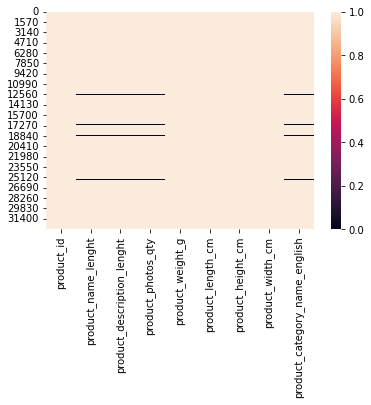

In [7]:
# we have a few products with no assigned categories.
products_cat = pd.merge(products, categories, on='product_category_name', how='left').drop(columns=['product_category_name'])

sns.heatmap(products_cat.notna())
plt.show()

In [8]:
# we don't need below dfs anymore, so we delete them for memory efficiency
del categories
del products
del dfs

gc.collect()

6508

#### 3.2. Merging gelocations with customers & sellers
Strategy: we keep customers & sellers dfs and left join geolocation data to enrich both dfs.<br/>
The geolocation dataset provides multiple lat, long info for each zip code prefix.<br/>
We take the average of lat, long for each zip code prefix and then left join it to the sellers and customers dfs.<br/>

In [9]:
geolocations.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,01037,-23.545622,-46.639294,sao paulo,SP
1,01046,-23.546082,-46.644821,sao paulo,SP
2,01046,-23.546129,-46.642952,sao paulo,SP
3,01041,-23.544392,-46.639500,sao paulo,SP
4,01035,-23.541578,-46.641605,sao paulo,SP


In [10]:
# grouping by zip code
geolocations_grouped = geolocations.groupby(['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state']).agg({
    'geolocation_lat':'mean', 'geolocation_lng':'mean'}).reset_index()

In [15]:
# ditribution of latitudes and longitudes
def show_map(df, lng_col, lat_col):   
    
    img = plt.imread('.\images\world-map.png')
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.scatterplot(data= df, x=df[lng_col], y=df[lat_col])
    ax.imshow(img, extent=[-130, 150, -60, 90], aspect='auto')
    ax.set_title('Geolocation map of data points', fontsize=14)
    plt.show()

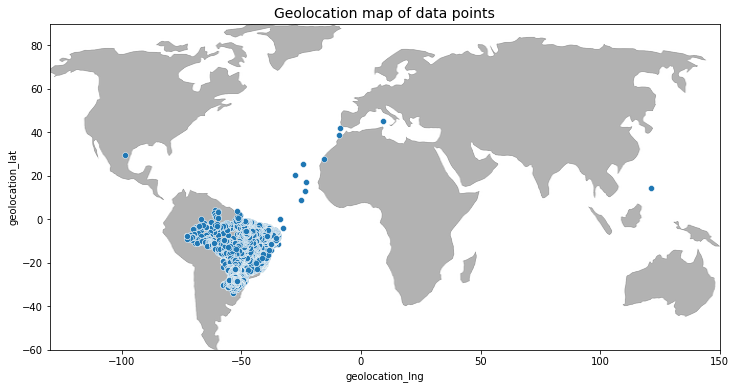

In [16]:
# we have a few points out of Brazil
show_map(geolocations_grouped, 'geolocation_lng', 'geolocation_lat')

We remove the outliers that fall out of Brazilian territory

In [17]:
# Brazils is confined within below latitudes and longitudes:
min_lat = -33.75116944
max_lat = 5.27438888
min_lang = -73.98283055
max_lang = -34.79314722

lat_mask = (geolocations_grouped.geolocation_lng >= min_lang) & (geolocations_grouped.geolocation_lng <= max_lang)
lng_mask = (geolocations_grouped.geolocation_lat >= min_lat) & (geolocations_grouped.geolocation_lat <= max_lat)

geolocations_grouped = geolocations_grouped.loc[lat_mask & lng_mask, :]

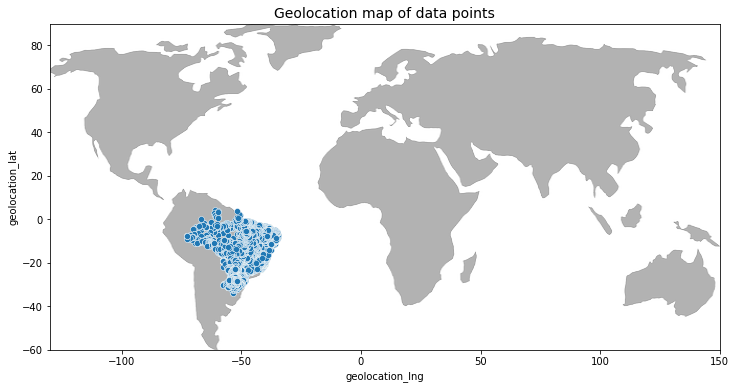

In [18]:
show_map(geolocations_grouped, 'geolocation_lng', 'geolocation_lat')

Cleaning the sellers dataset

In [19]:
# there is a mistmatch between geolocations data and sellers & customers
# for simplicity, we assume geolocations data is the source of truth and change some of the sellers data to match it
# doing some cleaning in the sellers dataset

cities_to_replace = {'riberao preto': 'ribeirão preto', 'santa barbara d´oeste': 'santa barbara d\'oeste', 'sao paulo - sp': 'sao paulo', 's jose do rio preto': 'sao jose do rio preto', 'scao jose do rio pardo':'sao jose do rio pardo', 'sao  paulo': 'sao paulo', 'andira-pr': 'andirá', 'brejao': 'brejão', 'ribeirao preto / sao paulo': 'ribeirao preto', 'vendas@creditparts.com.br': 'maringa', 'vicente de carvalho': 'guaruja', 'pirituba': 'sao paulo', 'andirá': 'barra do jacare', 'gama': 'brasilia', 'sao paulo / sao paulo': 'sao paulo', 'garulhos': 'guarulhos'}
sellers.replace({'seller_city' : cities_to_replace}, inplace=True)

sellers.loc[sellers.seller_city == 'volta redonda', 'seller_state'] = 'RJ'
sellers.loc[sellers.seller_city == 'itajai', 'seller_state'] = 'SC'
sellers.loc[sellers.seller_city == 'belo horizonte', 'seller_state'] = 'MG'
sellers.loc[sellers.seller_city == 'florianopolis', 'seller_state'] = 'SC'

sellers.loc[[1233, 1905, 2510], 'seller_state'] = 'PR'
sellers.loc[1656, 'seller_state'] = 'MG'
sellers.loc[874, 'seller_city'] = 'arraial d\'ajuda'

sellers.loc[sellers.seller_zip_code_prefix == '86385', 'seller_city'] = 'barra do jacare'
sellers.loc[sellers.seller_zip_code_prefix == '12903', 'seller_city'] = 'bragança paulista'
sellers.loc[sellers.seller_zip_code_prefix == '04776', 'seller_city'] = 'sao paulo'
sellers.loc[sellers.seller_zip_code_prefix == '05141', 'seller_city'] = 'sao paulo'
sellers.loc[sellers.seller_zip_code_prefix == '16021', 'seller_city'] = 'aracatuba'

We add location coordinates to sellers and customers datasets from the geolocation dataset

In [20]:
# merging geolocation data
customers_geo = pd.merge(customers, geolocations_grouped, left_on= ['customer_zip_code_prefix', 'customer_city', 'customer_state'], right_on=['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state'], how='left', validate='m:1').drop(columns=['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state'])
sellers_geo = pd.merge(sellers, geolocations_grouped, left_on= ['seller_zip_code_prefix', 'seller_city', 'seller_state'], right_on=['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state'], how='left', validate='m:1').drop(columns=['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state'])

customers_geo.rename(columns={'geolocation_lat': 'customer_geo_lat', 'geolocation_lng': 'customer_geo_lng'}, inplace=True)
sellers_geo.rename(columns={'geolocation_lat': 'seller_geo_lat', 'geolocation_lng': 'seller_geo_lng'}, inplace=True)

check_dfs({'customers_geo': customers_geo, 'sellers_geo':sellers_geo})

,df,column,count,nulls,dtype,smaple_value
0,customers_geo,customer_id,99441,0,object,06b8999e2fba1a1fbc88172c00ba8bc7
1,customers_geo,customer_unique_id,99441,0,object,861eff4711a542e4b93843c6dd7febb0
2,customers_geo,customer_zip_code_prefix,99441,0,object,14409
3,customers_geo,customer_city,99441,0,object,franca
4,customers_geo,customer_state,99441,0,object,SP
5,customers_geo,customer_geo_lat,99112,329,float32,-20.498489
6,customers_geo,customer_geo_lng,99112,329,float32,-47.396931
7,sellers_geo,seller_id,3095,0,object,3442f8959a84dea7ee197c632cb2df15
8,sellers_geo,seller_zip_code_prefix,3095,0,object,13023
9,sellers_geo,seller_city,3095,0,object,campinas


In [21]:
# # we don't need below dfs anymore, so we delete them for memory efficiency
del geolocations
del geolocations_grouped
del customers
del sellers

gc.collect()

10329

#### 3.3. Joining ecommerce datasets

We are concerned with data related to orders, so we keep orders_dataset as the centerpiece and left join all the other datasets. (however, in this dataset, left join and outer join yield the same result) then we can deal with the missing values based on application.

In [22]:
# merging dfs
sales = pd.merge(orders, items, on='order_id', how='inner')
sales = pd.merge(sales, payments, on='order_id', how='inner')
sales = pd.merge(sales, reviews, on='order_id', how='inner')
sales = pd.merge(sales, products_cat, on='product_id', how='inner')
sales = pd.merge(sales, customers_geo, on='customer_id', how='inner')
sales = pd.merge(sales, sellers_geo, on='seller_id', how='inner')

We downcast the numerical data for memory efficiency

In [23]:
# below columns contain Nan values so can not be converted to int or unit8 therefore we downcast to float32

convert_list = ['product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'order_item_id', 'payment_sequential', 'payment_installments','review_score']
sales[convert_list] = sales[convert_list].astype('float32')

In [24]:
sales_initial_length = len(sales)
sales_initial_length

117329

### 4. Cleaning sales dataframe

In [25]:
check_dfs({'sales': sales}).drop(columns=['df'])

,column,count,nulls,dtype,smaple_value
0,order_id,117329,0,object,e481f51cbdc54678b7cc49136f2d6af7
1,customer_id,117329,0,object,9ef432eb6251297304e76186b10a928d
2,order_status,117329,0,object,delivered
3,order_purchase_timestamp,117329,0,datetime64[ns],2017-10-02 10:56:33
4,order_approved_at,117314,15,datetime64[ns],2017-10-02 11:07:15
5,order_delivered_carrier_date,116094,1235,datetime64[ns],2017-10-04 19:55:00
6,order_delivered_customer_date,114858,2471,datetime64[ns],2017-10-10 21:25:13
7,order_estimated_delivery_date,117329,0,datetime64[ns],2017-10-18 00:00:00
8,order_item_id,117329,0,float32,1.0
9,product_id,117329,0,object,87285b34884572647811a353c7ac498a


Checking order dates

In [26]:
sales.order_purchase_timestamp.dt.year.value_counts()

2018    63458
2017    53488
2016      383
Name: order_purchase_timestamp, dtype: int64

In [27]:
period_index = pd.date_range(start='2016-09', end='2018-09', freq='M').to_period('M')
order_dates = pd.to_datetime(sales['order_purchase_timestamp']).dt.to_period('M').to_frame().rename(columns={'order_purchase_timestamp': 'order_purchase_period'})
order_dates_count = order_dates.order_purchase_period.value_counts(sort=False).to_frame()
order_dates_count = order_dates_count.reindex(period_index, fill_value=0)

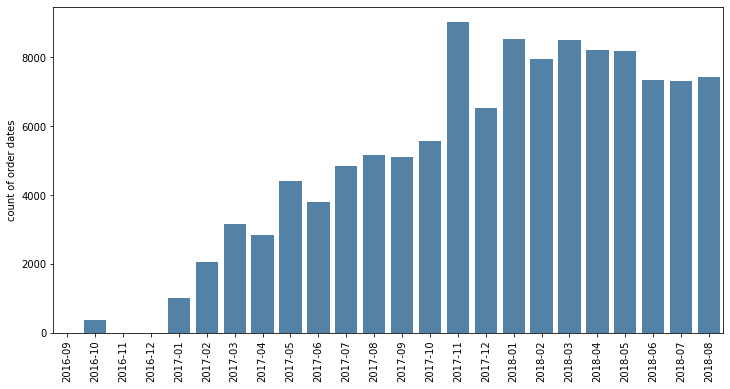

In [28]:
# We don't have consistent data for 2016 orders, so we drop 2016 data
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=order_dates_count.index, y=order_dates_count.order_purchase_period, color = 'steelblue')
ax.set_xticklabels(order_dates_count.index, rotation=90)
ax.set_ylabel('count of order dates')
plt.show()

In [29]:
# dropping 2016 data
sales = sales.loc[sales.order_purchase_timestamp.dt.year != 2016, :]
sales.order_purchase_timestamp.dt.year.value_counts()

2018    63458
2017    53488
Name: order_purchase_timestamp, dtype: int64

#### 4.1. Handling the missing values

In [30]:
# Null values in below columns are due to absence so we fill them with proper value

sales.review_comment_title.fillna('no title', inplace=True)
sales.review_comment_message.fillna('no message', inplace=True)
sales.product_category_name_english.fillna('no category', inplace=True)
sales.product_description_lenght.fillna(0, inplace=True)  # product has product_id with no description_lenght
sales.product_name_lenght.fillna(0, inplace=True)  # product has product_id with no name_lenght
sales.product_photos_qty.fillna(0, inplace=True)  # product has product_id with no photos_qty

In [31]:
# function to check null percentage for columns

def check_null_percent(df):
    null_percent = df.isna().sum(axis=0).div(len(df)).mul(100).sort_values(ascending=False)
    return null_percent.loc[null_percent > 0]

In [32]:
# checking null %
check_null_percent(sales)

order_delivered_customer_date    2.073607
order_delivered_carrier_date     1.024404
seller_geo_lng                   0.804645
seller_geo_lat                   0.804645
customer_geo_lng                 0.324936
customer_geo_lat                 0.324936
product_weight_g                 0.017102
product_length_cm                0.017102
product_height_cm                0.017102
product_width_cm                 0.017102
order_approved_at                0.012826
dtype: float64

Filling missing dates

We use order_purchase_timestamp and order_estimated_delivery_date to fill the missing data in other columns

In [33]:
check_dfs({'sales': sales}).drop(columns=['df']).iloc[3: 8, :]

,column,count,nulls,dtype,smaple_value
3,order_purchase_timestamp,116946,0,datetime64[ns],2017-10-02 10:56:33
4,order_approved_at,116931,15,datetime64[ns],2017-10-02 11:07:15
5,order_delivered_carrier_date,115748,1198,datetime64[ns],2017-10-04 19:55:00
6,order_delivered_customer_date,114521,2425,datetime64[ns],2017-10-10 21:25:13
7,order_estimated_delivery_date,116946,0,datetime64[ns],2017-10-18 00:00:00


In [34]:
date_columns = check_dfs({'sales': sales}).drop(columns=['df']).iloc[3: 8, 0]

Handling missing values in order_approved_at column

In [35]:
sales.loc[sales.order_approved_at.isna(), date_columns]

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
25649,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
30133,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
30135,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
30212,2017-02-18 17:15:03,NaT,2017-02-22 11:23:11,2017-03-03 18:43:43,2017-03-31
58887,2017-02-18 15:52:27,NaT,2017-02-23 03:09:14,2017-03-07 13:57:47,2017-03-29
59184,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
59330,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
70007,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
82979,2017-02-18 22:49:19,NaT,2017-02-22 11:31:06,2017-03-02 12:06:06,2017-03-21
82980,2017-02-18 22:49:19,NaT,2017-02-22 11:31:06,2017-03-02 12:06:06,2017-03-21


In [36]:
# mean value of 10 hours from order time seems reasonable enough to use to fill the missing values
sales.order_approved_at.sub(sales.order_purchase_timestamp).describe()

count                       116931
mean     0 days 10:26:59.880664665
std      0 days 21:52:24.143107590
min                0 days 00:00:00
25%                0 days 00:12:56
50%                0 days 00:20:42
75%         0 days 14:55:06.500000
max               60 days 10:51:59
dtype: object

In [37]:
mean_diff_order_approved_at = sales.order_approved_at.sub(sales.order_purchase_timestamp).mean()
order_approved_at_fillna = (sales.order_purchase_timestamp + (sales.order_approved_at.sub(sales.order_purchase_timestamp)).mean()).dt.round('1s')

sales['order_approved_at'] = sales.order_approved_at.fillna(order_approved_at_fillna)

##### Filling nans in order_delivered_carrier_date
Since we lose a lot of good information if we drop the missing values, we will fill them using order_approved_at column

One of the reasons we don't have customer delivery date is becuase of the order status, so let's check it:

In [38]:
sales.order_status.value_counts()

delivered     114528
shipped         1158
canceled         538
processing       368
invoiced         351
approved           3
Name: order_status, dtype: int64

We drop the canceled orders and impute delivery date for the rest of orders

In [39]:
sales = sales.loc[sales.order_status != 'canceled']
sales.order_status.value_counts()

delivered     114528
shipped         1158
processing       368
invoiced         351
approved           3
Name: order_status, dtype: int64

In [40]:
check_dfs({'sales': sales}).drop(columns=['df']).iloc[3: 8, :]

,column,count,nulls,dtype,smaple_value
3,order_purchase_timestamp,116408,0,datetime64[ns],2017-10-02 10:56:33
4,order_approved_at,116408,0,datetime64[ns],2017-10-02 11:07:15
5,order_delivered_carrier_date,115684,724,datetime64[ns],2017-10-04 19:55:00
6,order_delivered_customer_date,114520,1888,datetime64[ns],2017-10-10 21:25:13
7,order_estimated_delivery_date,116408,0,datetime64[ns],2017-10-18 00:00:00


In [41]:
sales.order_delivered_carrier_date.sub(sales.order_approved_at).agg(['mean', 'std', 'quantile'])

mean       2 days 19:37:16.992228830
std        3 days 11:17:27.455296866
quantile      1 days 20:09:07.500000
dtype: timedelta64[ns]

In [42]:
order_delivered_carrier_date_fillna = (sales.order_approved_at + (sales.order_delivered_carrier_date.sub(sales.order_approved_at)).mean()).dt.round('1s')
sales['order_delivered_carrier_date'] = sales.order_delivered_carrier_date.fillna(order_delivered_carrier_date_fillna)

In [43]:
sales.order_delivered_customer_date.sub(sales.order_delivered_carrier_date).agg(['mean', 'std', 'quantile'])

mean       9 days 04:13:29.930370240
std        8 days 13:29:45.001312011
quantile             7 days 01:29:14
dtype: timedelta64[ns]

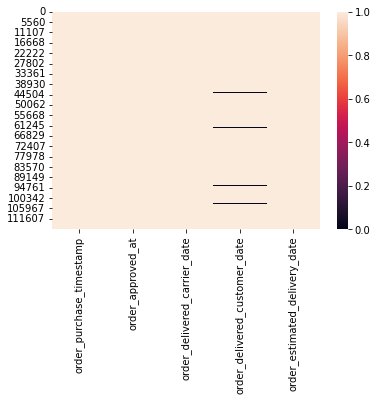

In [44]:
sns.heatmap(sales[date_columns].notna())
plt.show()

In [45]:
order_delivered_customer_date_fillna = (sales.order_delivered_carrier_date + (sales.order_delivered_customer_date.sub(sales.order_delivered_carrier_date)).mean()).dt.round('1s')
sales['order_delivered_customer_date'] = sales.order_delivered_customer_date.fillna(order_delivered_customer_date_fillna)

In [46]:
sales[date_columns].isna().sum()

order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

In [47]:
# checking null %
check_null_percent(sales)

seller_geo_lng       0.806646
seller_geo_lat       0.806646
customer_geo_lng     0.321284
customer_geo_lat     0.321284
product_weight_g     0.017181
product_length_cm    0.017181
product_height_cm    0.017181
product_width_cm     0.017181
dtype: float64

Handling the missing values in product spec columns

In [48]:
# we have 20 rows with missing product specs
product_specs_cols = ['product_id', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']
sales.loc[sales.product_weight_g.isna(), product_specs_cols].isna().sum()

product_id            0
product_weight_g     20
product_length_cm    20
product_height_cm    20
product_width_cm     20
dtype: int64

In [49]:
# we have 2 products with no specification in the dataset
missing_product_ids = sales.loc[sales.product_weight_g.isna(), 'product_id'].unique()
missing_product_ids

array(['5eb564652db742ff8f28759cd8d2652a',
       '09ff539a621711667c43eba6a3bd8466'], dtype=object)

In [50]:
# checking to see if we have spec for these products in other rows. We don't!
sales.loc[sales.product_id.isin(missing_product_ids), product_specs_cols].count()

product_id           20
product_weight_g      0
product_length_cm     0
product_height_cm     0
product_width_cm      0
dtype: int64

In [51]:
# so we drop these rows since we can not imputate data for them
sales.dropna(subset=['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'], inplace=True)

In [52]:
# checking null %
check_null_percent(sales)

seller_geo_lng      0.806784
seller_geo_lat      0.806784
customer_geo_lng    0.321339
customer_geo_lat    0.321339
dtype: float64

Dealing with missing data in lng & lat columns:<br/>

We fill lat and lng based on the average of lat and lng for each city we calculated before since the missing values are less than 1% <br/>
Alternatively, we can use third party data for missing zip code prefixes & use the average to fill nans

In [53]:
# creatig city mean values for lat and lng
seller_lng_zip_mean = sales.groupby(['seller_state', 'seller_city'])['seller_geo_lng'].transform('mean')
seller_lat_zip_mean = sales.groupby(['seller_state', 'seller_city'])['seller_geo_lat'].transform('mean')

customer_lng_zip_mean = sales.groupby(['customer_state', 'customer_city'])['customer_geo_lng'].transform('mean')
customer_lat_zip_mean = sales.groupby(['customer_state', 'customer_city'])['customer_geo_lat'].transform('mean')

# filling missing values with zip code prefix means
sales.seller_geo_lng.fillna(seller_lng_zip_mean, inplace=True)
sales.seller_geo_lat.fillna(seller_lat_zip_mean, inplace=True)

sales.customer_geo_lng.fillna(customer_lng_zip_mean, inplace=True)
sales.customer_geo_lat.fillna(customer_lat_zip_mean, inplace=True)

# checking the impact on null %
check_null_percent(sales)

seller_geo_lng      0.307592
seller_geo_lat      0.307592
customer_geo_lng    0.085060
customer_geo_lat    0.085060
dtype: float64

We drop the remaining rows since there are some cities in sellers and customers datasets with no corresponding values in geolocations dataset.<br/>
Alternatively, we can use third party data for missing zip code prefixes & use the average to fill nans

In [54]:
## dropping rows with missing values

sales.dropna(subset=['seller_geo_lng'], inplace=True)
sales.dropna(subset=['customer_geo_lng'], inplace=True)

# checking null %
check_null_percent(sales)

Series([], dtype: float64)

In [55]:
sales.shape

(115931, 43)

#### 4.2. checking for duplicates & outliers

In [56]:
# checking for duplicate rows
sales.duplicated().sum()

0

In [57]:
# based on application and EDA, we can later on decide about how to handle outliers
sales.describe(percentiles=[0.25, 0.5, 0.75, 0.9]).loc[['min', 'max', 'std', 'mean', '25%', '50%', '75%', '90%'], :].round(1).swapaxes(axis1=1, axis2=0)

,min,max,std,mean,25%,50%,75%,90%
order_item_id,1.0,21.0,0.7,1.2,1.0,1.0,1.0,2.0
price,0.9,6735.0,181.4,120.0,39.9,74.9,133.6,229.0
freight_value,0.0,409.7,15.7,20.0,13.1,16.3,21.2,34.0
payment_sequential,1.0,26.0,0.7,1.1,1.0,1.0,1.0,1.0
payment_installments,0.0,24.0,2.8,2.9,1.0,2.0,4.0,8.0
payment_value,0.0,13664.1,263.9,171.4,60.7,108.0,188.9,336.0
review_score,1.0,5.0,1.4,4.0,4.0,5.0,5.0,5.0
product_name_lenght,0.0,76.0,11.5,48.1,42.0,51.0,57.0,59.0
product_description_lenght,0.0,3992.0,652.9,773.8,340.0,594.0,974.5,1566.0
product_photos_qty,0.0,20.0,1.7,2.2,1.0,1.0,3.0,5.0


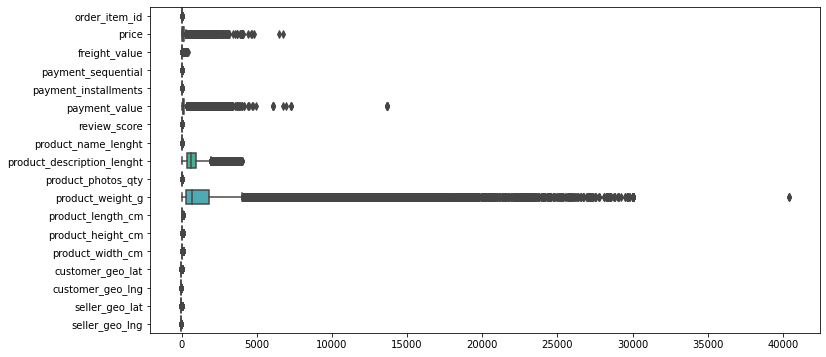

In [58]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=sales.select_dtypes('number'), orient='h')
plt.show()

#### 4.3. Downcasting & Saving the outcome

In [59]:
sales.reset_index(drop=True, inplace=True)

# number of rows after dropping missing values
print(f'Total number of rows dropped during data wrangling: {sales_initial_length - len(sales)}')
print(f'% of rows dropped: {round((sales_initial_length - len(sales)) / sales_initial_length * 100, 2)}')

Total number of rows dropped during data wrangling: 1398
% of rows dropped: 1.19


In [60]:
# reducing the file size
def downcast(df):
    
    ## downcasting floats
    f_cols= df.select_dtypes(['float', 'float64']).columns
    df[f_cols] = df[f_cols].apply(pd.to_numeric, downcast='float')

    ## downcasting ints
    i_cols = df.select_dtypes(['integer', 'int', 'int32']).columns
    df[i_cols] = df[i_cols].apply(pd.to_numeric, downcast='unsigned')

    return df

We downcast the data before exporting it in order to create a data type mapper along with the file when we use the data in other projects

In [61]:
# downcasting the numerical data
int_cols = ['product_description_lenght', 'product_weight_g', 'order_item_id', 'payment_sequential', 'payment_installments', 'review_score', 'product_name_lenght', 'product_photos_qty', 'product_length_cm', 'product_height_cm', 'product_width_cm']
sales[int_cols] = sales[int_cols].astype('int')

downcast(sales)
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115931 entries, 0 to 115930
Data columns (total 43 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115931 non-null  object        
 1   customer_id                    115931 non-null  object        
 2   order_status                   115931 non-null  object        
 3   order_purchase_timestamp       115931 non-null  datetime64[ns]
 4   order_approved_at              115931 non-null  datetime64[ns]
 5   order_delivered_carrier_date   115931 non-null  datetime64[ns]
 6   order_delivered_customer_date  115931 non-null  datetime64[ns]
 7   order_estimated_delivery_date  115931 non-null  datetime64[ns]
 8   order_item_id                  115931 non-null  uint8         
 9   product_id                     115931 non-null  object        
 10  seller_id                      115931 non-null  object        
 11  

In [62]:
# Exporting the cleaned file
sales.to_csv('sales_cleaned.csv', index=False)

In [63]:
# Exporting data type metadata
dtypes_mapper = sales.dtypes.reset_index().rename(columns={'index': 'column_name', 0: 'data_type'})
dtypes_mapper.to_csv('sales_cleaned_data_map.csv', index=False)
dtypes_mapper.head()

,column_name,data_type
0,order_id,object
1,customer_id,object
2,order_status,object
3,order_purchase_timestamp,datetime64[ns]
4,order_approved_at,datetime64[ns]


In [64]:
# checking the size of the file
def file_size(file):
    f_size = os.path.getsize(file)
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if abs(f_size) < 1024.0:
            return f'{f_size:3.1f}{unit}'
        f_size /= 1024.0
    return f'OOPS! This file is too big!'

In [65]:
file_size('sales_cleaned.csv')

'63.2MB'

In [66]:
file_size('sales_cleaned_data_map.csv')

'1.2KB'

### 5. Joining marketing datasets
Since we have a lot of missing values, the best way is to use the original files and based on use join them later in the future projects.

In [67]:
marketing = pd.merge(mql, closed_deals, on='mql_id', how='outer')
marketing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 7999
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   mql_id                         8000 non-null   object        
 1   first_contact_date             8000 non-null   datetime64[ns]
 2   landing_page_id                8000 non-null   object        
 3   origin                         7940 non-null   object        
 4   seller_id                      842 non-null    object        
 5   sdr_id                         842 non-null    object        
 6   sr_id                          842 non-null    object        
 7   won_date                       842 non-null    datetime64[ns]
 8   business_segment               841 non-null    object        
 9   lead_type                      836 non-null    object        
 10  lead_behaviour_profile         665 non-null    object        
 11  has_company      

#### Cleaning marketing dataset

assumption: categories in each column are correct and don't need sanity check. <br/>
This is assumed because there is not enough information for sanity check. <br/>
e.g. whether 'other_publicities' and 'other' categories in origin column are well-defined and are seperate categories

In [68]:
marketing.origin.value_counts()

organic_search       2296
paid_search          1586
social               1350
unknown              1099
direct_traffic        499
email                 493
referral              284
other                 150
display               118
other_publicities      65
Name: origin, dtype: int64

In [69]:
# checking null %
check_null_percent(marketing)

has_company                      99.2125
has_gtin                         99.2000
average_stock                    99.1750
declared_product_catalog_size    99.1375
lead_behaviour_profile           91.6875
business_type                    89.6000
lead_type                        89.5500
business_segment                 89.4875
declared_monthly_revenue         89.4750
won_date                         89.4750
sr_id                            89.4750
sdr_id                           89.4750
seller_id                        89.4750
origin                            0.7500
dtype: float64

In [70]:
# filling missing values

marketing.origin.fillna('unknown', inplace=True)  # we don't use "unknown" to not mix the filled na with those filled by reps
marketing.seller_id.fillna('empty', inplace=True)
marketing.sdr_id.fillna('empty', inplace=True)
marketing.sr_id.fillna('empty', inplace=True)
marketing.business_segment.fillna('unknown', inplace=True)
marketing.lead_type.fillna('unknown', inplace=True)
marketing.lead_behaviour_profile.fillna('unknown', inplace=True)
marketing.has_company.fillna('unknown', inplace=True)
marketing.has_gtin.fillna('unknown', inplace=True)  # True, False
marketing.average_stock.fillna('unknown', inplace=True)
marketing.business_type.fillna('unknown', inplace=True)

marketing.reindex(columns= ['won_date'], fill_value=0)

# checking null %
check_null_percent(marketing)

declared_product_catalog_size    99.1375
declared_monthly_revenue         89.4750
won_date                         89.4750
dtype: float64